### Import Statements

In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import astropy.constants as c

%matplotlib inline

### Search For Tess Cutout of Target

In [2]:
ticid = 332624864 
starName = "TIC " + str(ticid)
search_result = lk.search_targetpixelfile(starName)

In [3]:
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 25,2020,SPOC,120,332624864,0.0
1,TESS Sector 26,2020,SPOC,120,332624864,0.0
2,TESS Sector 40,2021,SPOC,120,332624864,0.0
3,TESS Sector 52,2022,SPOC,120,332624864,0.0
4,TESS Sector 54,2022,SPOC,120,332624864,0.0
5,TESS Sector 80,2024,SPOC,20,332624864,0.0
6,TESS Sector 79,2024,SPOC,20,332624864,0.0
7,TESS Sector 81,2024,SPOC,20,332624864,0.0
8,TESS Sector 74,2024,SPOC,20,332624864,0.0


### Download File

In [4]:
tpf = search_result[7].download()

### Create Aperture of Pixels 1.5 Times Above Median Flux and Plot

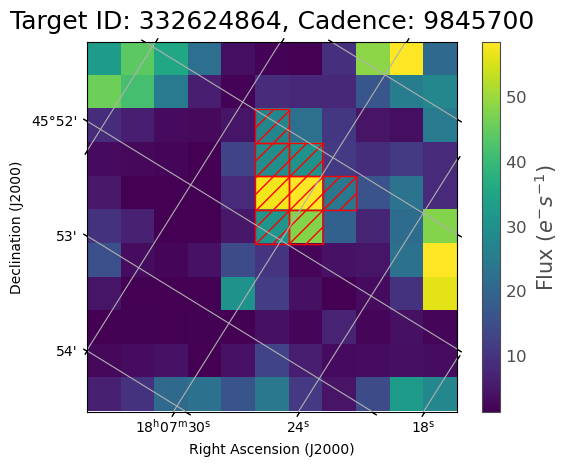

In [5]:
aperture_mask = tpf.create_threshold_mask(threshold=1.5)

fig, ax = plt.subplots(subplot_kw={'projection': tpf.wcs})  # Use WCS projection
tpf.plot(ax=ax, aperture_mask=aperture_mask)  # Plot TPF imag

#Label axes with RA/Dec
ax.set_xlabel("Right Ascension (J2000)")
ax.set_ylabel("Declination (J2000)")
plt.show()

### Create Light Curve

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

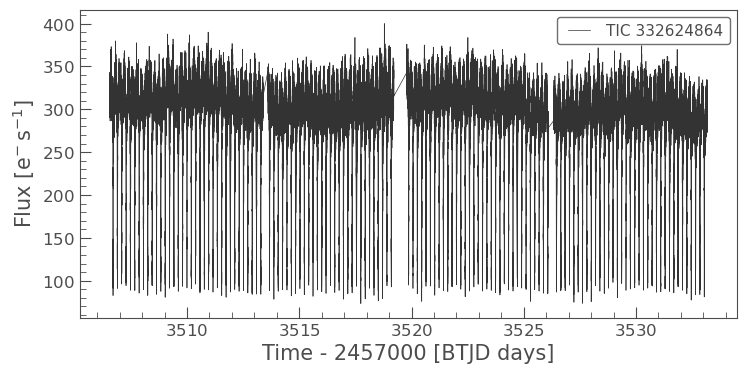

In [6]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aperture_mask)
uncorrected_lc.plot()

### Removing Scattering

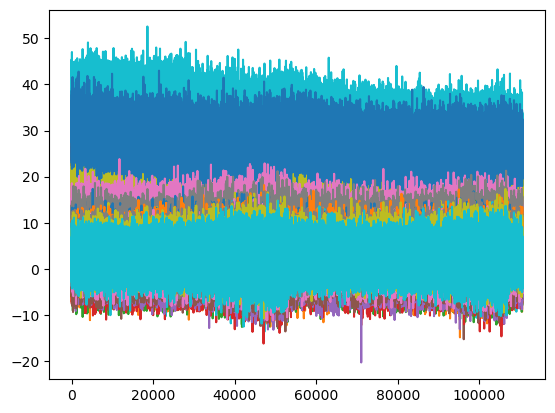

In [7]:
regressors = tpf.flux[:, ~aperture_mask]
regressors.shape
plt.plot(regressors[:, :30]);

In [8]:
from lightkurve.correctors import DesignMatrix
dm = DesignMatrix(regressors, name='regressors')

In [9]:
dm

regressors DesignMatrix (110638, 113)

pca() reduces number of components in design matrix to 5

In [10]:
dm = dm.pca(2)

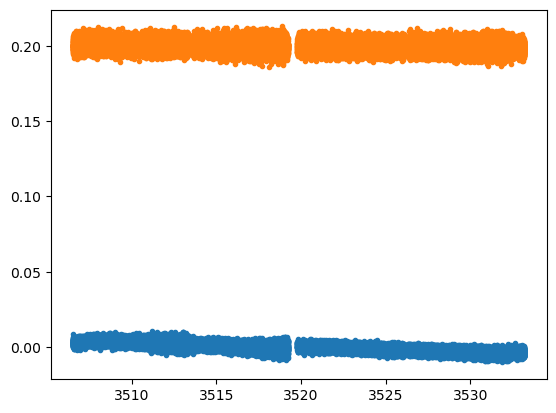

In [11]:
plt.plot(tpf.time.value, dm.values + np.arange(2)*0.2, '.');

<Axes: title={'center': 'regressors'}, xlabel='Component', ylabel='X'>

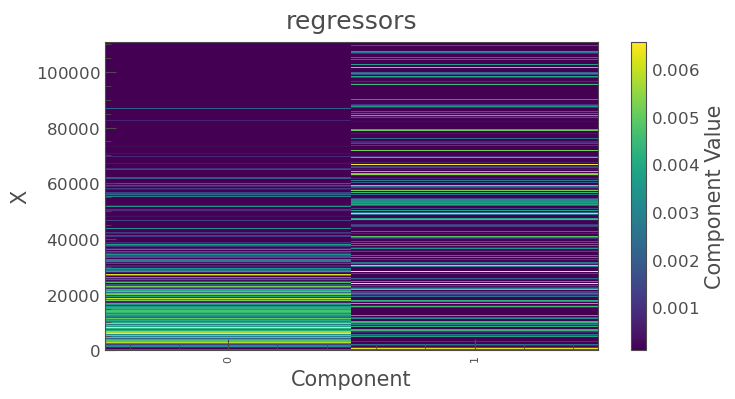

In [12]:
dm.plot()

need an “offset” term, to be able to fit the mean level of the light curve, append constant to design matrix

In [13]:
dm = dm.append_constant()

In [14]:
from lightkurve.correctors import RegressionCorrector
corrector = RegressionCorrector(uncorrected_lc)

In [15]:
corrector

RegressionCorrector (ID: 332624864)

correct the light curve by passing in design matrix

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

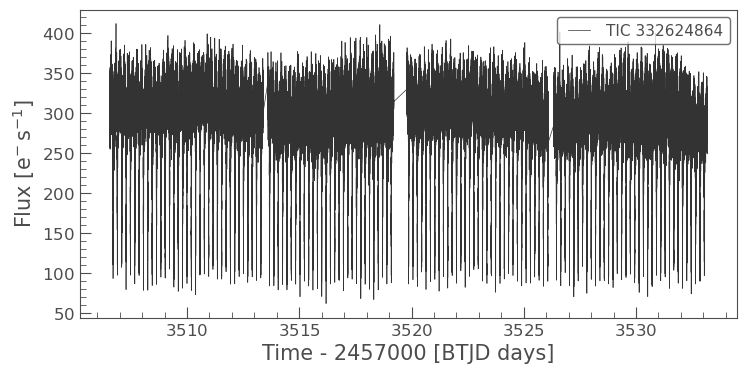

In [16]:
corrected_lc = corrector.correct(dm)
corrected_lc.plot()

### Diagnosing the Correction

array([<Axes: ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

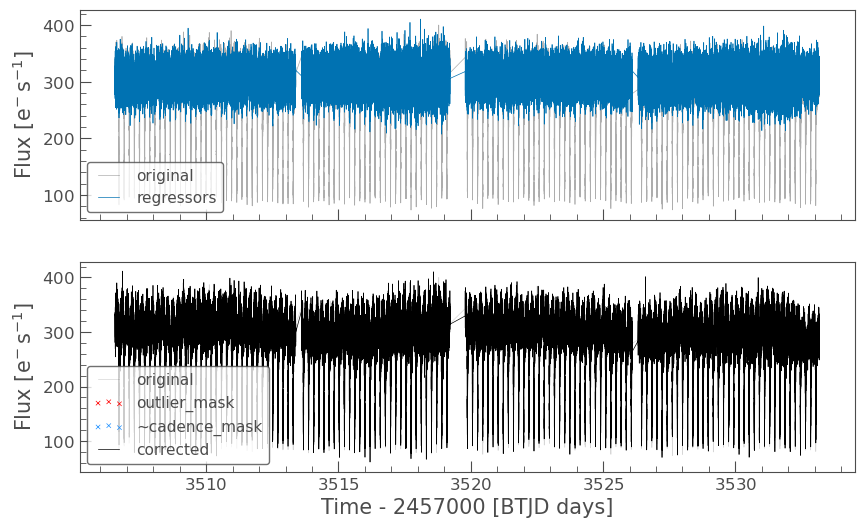

In [17]:
corrector.diagnose()

regression corrector assumes you want to removethe trend and set thelight curve to the mean level of the uncorrected light curve. not true for TESS scattered light, TESS FFIs have additive background. want to reduce the flux to the lowest recorded level, assuming that at that point the contribution from scattered light is approximately zero.

In [18]:
corrector.model_lc

time,flux,flux_err
,electron / s,electron / s
Time,float64,float64
3506.554028095731,4.8773474324927975,0.0
3506.554259575243,-26.67029898550345,0.0
3506.554491054522,9.289184341926614,0.0
3506.554722533801,18.14797919979202,0.0
3506.55495401308,-20.766551899927208,0.0
3506.555185492359,23.26656048502059,0.0
3506.5554169718716,6.842313168435453,0.0
3506.555648451151,17.505066653296808,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

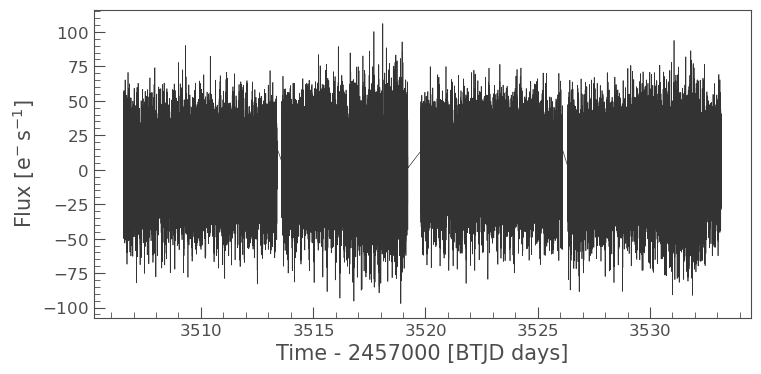

In [19]:
model = corrector.model_lc
model.plot()

model drops below zero. this is impossible, the scattered light can’t be removing flux from our target

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

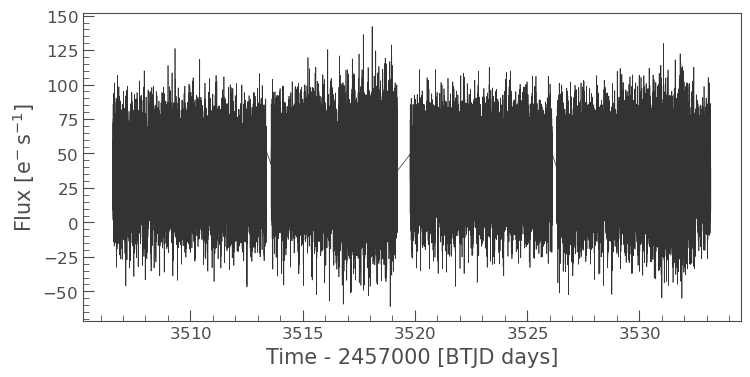

In [20]:
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)
model.plot()

In [21]:
corrected_lc = uncorrected_lc - model

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

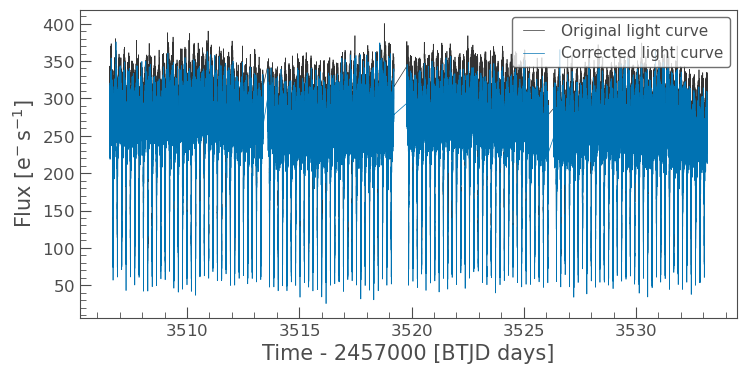

In [22]:
ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve')

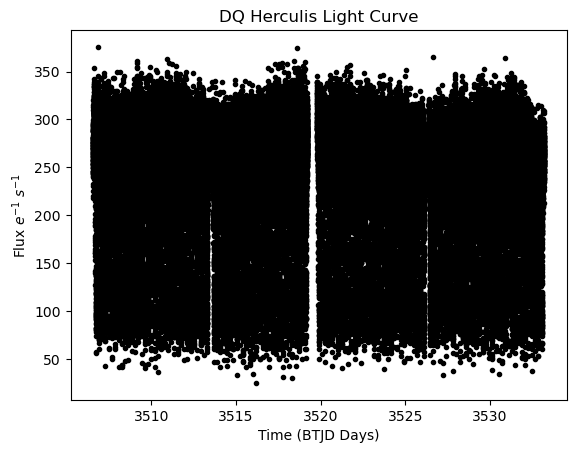

In [23]:
plt.plot(corrected_lc.time.value,corrected_lc.flux.value,'k.')
plt.title('DQ Herculis Light Curve')
plt.ylabel('Flux $e^{-1}$ $s^{-1}$')
plt.xlabel('Time (BTJD Days)')
plt.show()

In [24]:
time_btjd = tpf.time.value

time_jd = time_btjd + 2457000

# Convert to a readable format (e.g., ISO)
from astropy.time import Time
time_iso = Time(time_jd, format='jd').iso

print(time_iso[0]) 
print(time_iso[-1])

2024-07-15 01:17:48.027
2024-08-10 16:17:45.007


In [25]:
a = corrected_lc.time.value
b = corrected_lc.flux.value
c = corrected_lc.flux_err.value

dq_her7 = np.vstack([a,b,c])

np.savetxt("dq_her7.csv", dq_her7, delimiter=",", fmt="%s")